In [45]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np

H_0 = 70 # Hubble constant (arguable value between 65 to 73)

def multi_color(delta_m_15):
    M_max_V = -19.504 + 0.736*delta_m_15 + 0.182*(delta_m_15)**2 + 5*np.log10(H_0)
    return M_max_V


def phillips_relation(delta_m_15):
    M_max_B = -21.726 + 2.698*delta_m_15
    return M_max_B


# File containing the supernova data
file_path = "Supernova_Ia/table4.dat"

# Step 1: Read the file into a pandas DataFrame
# Adjust `delim_whitespace=True` for space-separated values
columns = ["prefix", "SN", "JD", "U_mag", "U_err", "B_mag", "B_err", "V_mag", "V_err", "R_mag", "R_err", "I_mag", "I_err", "Source"]
df = pd.read_csv(file_path, comment="#", sep="[ \t]+", engine="python", header=0,
                 names=columns)


# filter out unneeded magnitudes as the phillips relation is in B mag (U_mag because if NaN values occur everything gets shifted to the left)
UB_filter = df[["SN", "JD", "U_mag", "U_err", "B_mag", "B_err"]].dropna()


# get rid of the U mag too
B_filter = UB_filter[["SN", "JD", "B_mag", "B_err"]]


unique_sne = B_filter["SN"].unique()


# group the different SNe
sn_group = B_filter.groupby("SN")

Mags = []
for sn in unique_sne:
    sn_data = B_filter[B_filter["SN"] == sn]
    #print(sn_data)

    jd = sn_data["JD"].values
    b_mag = sn_data["B_mag"].values
    #print(b_mag)
    
    interp_func = interp1d(jd, b_mag, kind="linear", fill_value="extrapolate")

    # Find time of maximum brightness and corresponding magnitude
    max_idx = np.argmin(b_mag)  # Index of maximum brightness
    jd_max = jd[max_idx]
    m_b_max = float(b_mag[max_idx])

    # Calculate B-magnitude 15 days after maximum
    m_b_15 = float(interp_func(jd_max + 15))
    #print(m_b_15)

    # Calculate ∆m15
    delta_m15 = m_b_15 - m_b_max
    #print(delta_m15)
        
    

    print("SN", sn)
    print("max apparent B_mag:", m_b_max)
    M_V = multi_color(delta_m15)
    M_B = phillips_relation(delta_m15) # makes more sense
    #print("Multi-color:", M_V, "mag")
    print("Phillips:", M_B, "mag")

    # distance
    mu = m_b_max - M_B
    distance_pc = 10 ** ((mu + 5) / 5)

    print("distance:", distance_pc/(10**6), "Mpc")

    Mags.append(M_B)

    print()
print(Mags)

SN 1997E
max apparent B_mag: 15.62
Phillips: -17.741823516507154 mag
distance: 47.02888727933439 Mpc

SN 1997Y
max apparent B_mag: 15.379
Phillips: -19.52875108030319 mag
distance: 95.84075274500037 Mpc

SN 1997bp
max apparent B_mag: 14.085
Phillips: -18.50080358125243 mag
distance: 32.89733491656089 Mpc

SN 1997bq
max apparent B_mag: 14.824
Phillips: -20.689602495548257 mag
distance: 126.68362998030733 Mpc

SN 1997br
max apparent B_mag: 14.317
Phillips: -21.569354119989796 mag
distance: 150.4079610681096 Mpc

SN 1997cn
max apparent B_mag: 17.487
Phillips: -18.589085615141677 mag
distance: 164.14101816827812 Mpc

SN 1997cw
max apparent B_mag: 16.892
Phillips: -17.75162209959883 mag
distance: 84.86418013909434 Mpc

SN 1997dg
max apparent B_mag: 17.178
Phillips: -19.44386364709665 mag
distance: 211.0438638303612 Mpc

SN 1997do
max apparent B_mag: 14.626
Phillips: -21.33409683794899 mag
distance: 155.6035022254292 Mpc

SN 1997dt
max apparent B_mag: 15.402
Phillips: -18.56369940623588 mag


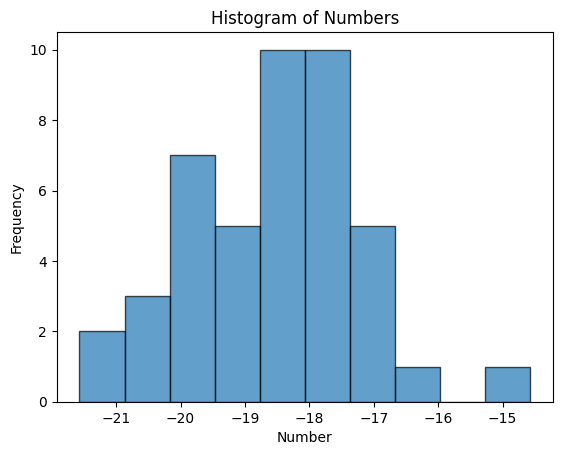

In [36]:
import matplotlib.pyplot as plt

plt.hist(Mags, bins=10, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Histogram of Numbers')


plt.show()

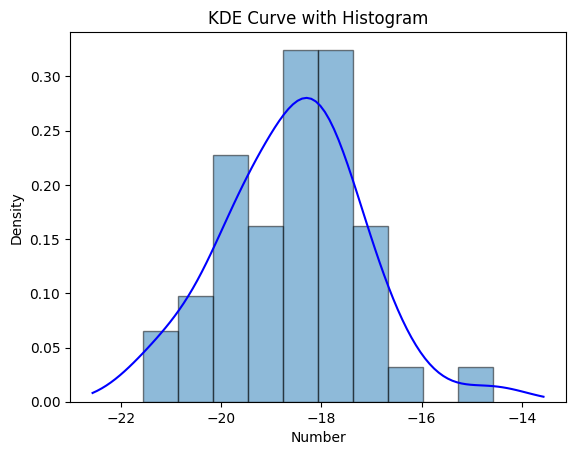

In [39]:
from scipy.stats import gaussian_kde

# Perform KDE
kde = gaussian_kde(Mags, bw_method=0.5)
x_vals = np.linspace(min(Mags) - 1, max(Mags) + 1, 100)
y_vals = kde(x_vals)

# Plot KDE curve
plt.plot(x_vals, y_vals, color='blue', label='KDE Curve')

# Add histogram for reference
plt.hist(Mags, bins=10, density=True, alpha=0.5, edgecolor='black', label='Histogram')

# Labels and legend
plt.xlabel('Number')
plt.ylabel('Density')
plt.title('KDE Curve with Histogram')


# Show plot
plt.show()

In [38]:
#moments

def moment_estimators(data):
    # Number of data points
    n = len(data)
    
    # First sample moment (mean)
    m1 = np.mean(data)
    
    # Second sample moment
    m2 = np.mean(np.square(data))
    
    # Variance (biased estimator using moment estimators)
    variance_biased = m2 - m1**2
    
    # Unbiased variance estimator
    variance_unbiased = np.var(data, ddof=1)  # Using numpy for ddof=1
    
    return m1, variance_biased, variance_unbiased

mean, variance_biased, variance_unbiased = moment_estimators(Mags)

print(f"Sample Mean (First Moment): {mean}")
print(f"Variance (Biased Estimator): {variance_biased}")
print(f"Variance (Unbiased Estimator): {variance_unbiased}")


Sample Mean (First Moment): -18.571667616794993
Variance (Biased Estimator): 1.8566515026130332
Variance (Unbiased Estimator): 1.8998294445342183
